In [2]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

In [3]:
''' The following shows the result of training various non-nerual network models on an augemnted version of the 
Kannada set with negative lebel equalling the positive lebel. models are trained on an tf-idf vectorizer
with dimensionality reduction.'''

' The following shows the result of training various non-nerual network models on an augemnted version of the \nKannada set with negative lebel equalling the positive lebel. models are trained on an tf-idf vectorizer\nwith dimensionality reduction.'

In [4]:
# import data
kan_train = pd.read_table("../../datasets/task_a/augmented/kan_train_negative_augmented.tsv")
kan_dev = pd.read_table("../../datasets/task_a/kan_sentiment_dev.tsv")

In [5]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [6]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


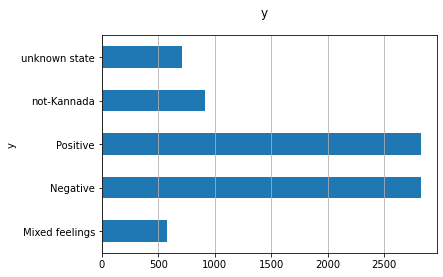

In [7]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [11]:
kan_train

,text,y
0,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,Negative
1,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Positive
2,Super sar song,not-Kannada
3,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...,Negative
4,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,Positive
...,...,...
7842,ಇಡೈಲಾ ಕೆಜಿಎಫ್ ಬಿಜಿಎಂ ಕೆಡತು ಎನಕು ಮಧುಮಥಾನ 🤔🤔🤔🤔🤯,Negative
7843,ಜಯಲಲಿತಾ ಮೇಡಂ ಅವರಿಗೆ ಅಮೋಘ ನಿಗ್ರಹ...,Negative
7844,ದಯವಿಟ್ಟು ಎಲ್ಲದರ ಚಿತ್ರ ತೆಗೆಯಿರಿ ಸರ್.,Negative
7845,ಭಾರತದ ಅತಿ ದೊಡ್ಡ ಹೆದ್ದಾರಿ! ಭಾರತದ ದೊಡ್ಡ ತಾರೆಗಳು!...,Negative


In [12]:
# Now we can define our training data and our dev data as well as targets
train = kan_train
test = kan_dev

y_train = kan_train['y'].values
y_test = kan_dev['y'].values


## Using Tf-Idf vectorizer

In [13]:
## Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [14]:
# now run thse vectorizers on the train data
corpus = train["text"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [15]:
X_train

<7847x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 56107 stored elements in Compressed Sparse Row format>

Text(0.5, 1.0, 'Sparse Matrix Sample')

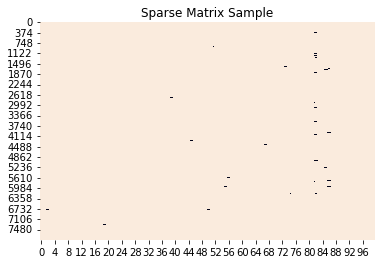

In [16]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

## reducing the vectorizers dimensionality

In [17]:
# reduce dimensionality through feature selection

y = y_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [18]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# Mixed feelings:
  . selected features: 410
  . top features: game,yava game,game name,yavadu,game yavdu,ಅದ ಪದ,bro game,bigg boss,32,game yavadu
 
# Negative:
  . selected features: 392
  . top features: super,ಲರ,song,bro,ಅಜ,ಇಲ,ಜಯ,ಆಹ,ಎಲ,ದರ
 
# Positive:
  . selected features: 189
  . top features: ದನ ಗಡ,ಗಡ ಇದ,ಪರ,guru,ಚರ,ದನ,ಅವತ,anna,ಇದ ಚರ,ಚರ ಅವತ
 
# not-Kannada:
  . selected features: 475
  . top features: bro,super,super bro,super song,song,anjali devi,devi,anjali,super super,nice
 
# unknown state:
  . selected features: 447
  . top features: yes,gta,gta bro,paramvah,paramvah music,lokanath,like,join,yes bro,abhi
 


## re-fitting the vectorizer on the new vocabulary gained through feature reduction

In [19]:
# we can now refit the vecotrizer on the corpus by giving this new set of words as input.
# producing a smaller feature matrix and a shorter vocabulary.
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


In [20]:
X_train.shape

(7847, 1700)

Text(0.5, 1.0, 'Sparse Matrix Sample')

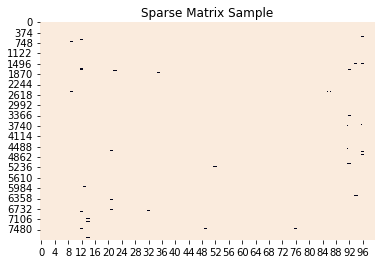

In [21]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

# Training a Naive Bayes Classifier

In [22]:
# Now we can train a model. i'm using a naive bayes classifier
classifier = naive_bayes.MultinomialNB()

In [23]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.52
Auc: 0.77
Detail:
                precision    recall  f1-score   support

Mixed feelings       1.00      0.02      0.04        52
      Negative       0.38      0.63      0.48       139
      Positive       0.57      0.73      0.64       321
   not-Kannada       0.64      0.25      0.36       110
 unknown state       0.55      0.09      0.15        69

      accuracy                           0.52       691
     macro avg       0.63      0.34      0.33       691
  weighted avg       0.58      0.52      0.47       691



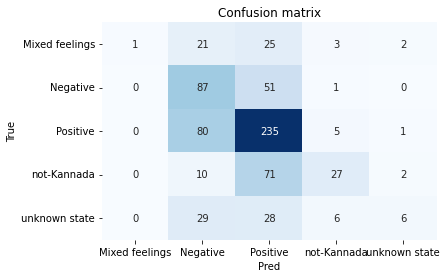

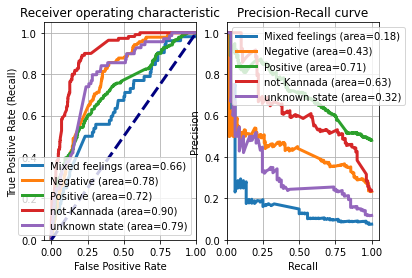

In [24]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()


In [25]:
#expolainer

## select observation
i = 1
txt_instance = test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Positive --> Pred: Positive | Prob: 0.89


/home/ubuntu/pyenv/lib/python3.6/site-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


# Training a cat boost classifier

In [32]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(
    iterations=1500, 
    learning_rate=1.5, 
    #loss_function='CrossEntropy'
)


In [33]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.3978169	total: 59.7ms	remaining: 1m 29s
1:	learn: 1.3867790	total: 103ms	remaining: 1m 17s
2:	learn: 1.3264683	total: 146ms	remaining: 1m 12s
3:	learn: 1.3139599	total: 189ms	remaining: 1m 10s
4:	learn: 1.2925152	total: 231ms	remaining: 1m 9s
5:	learn: 1.3084846	total: 276ms	remaining: 1m 8s
6:	learn: 1.3490215	total: 318ms	remaining: 1m 7s
7:	learn: 1.9499848	total: 362ms	remaining: 1m 7s
8:	learn: 6.0066015	total: 405ms	remaining: 1m 7s
9:	learn: 4.1179646	total: 447ms	remaining: 1m 6s
10:	learn: 2.9060044	total: 490ms	remaining: 1m 6s
11:	learn: 3.6558488	total: 533ms	remaining: 1m 6s
12:	learn: 2.8840208	total: 576ms	remaining: 1m 5s
13:	learn: 2.5427942	total: 619ms	remaining: 1m 5s
14:	learn: 2.1043396	total: 662ms	remaining: 1m 5s
15:	learn: 2.0901403	total: 705ms	remaining: 1m 5s
16:	learn: 2.0304655	total: 748ms	remaining: 1m 5s
17:	learn: 1.9864251	total: 790ms	remaining: 1m 5s
18:	learn: 1.9408969	total: 833ms	remaining: 1m 4s
19:	learn: 1.9079108	total: 876ms	re

165:	learn: 1.2544710	total: 7.11s	remaining: 57.2s
166:	learn: 1.2536656	total: 7.15s	remaining: 57.1s
167:	learn: 1.2505181	total: 7.2s	remaining: 57.1s
168:	learn: 1.2481303	total: 7.24s	remaining: 57s
169:	learn: 1.2442456	total: 7.28s	remaining: 57s
170:	learn: 1.2430318	total: 7.32s	remaining: 56.9s
171:	learn: 1.2416289	total: 7.37s	remaining: 56.9s
172:	learn: 1.2405509	total: 7.41s	remaining: 56.8s
173:	learn: 1.2396320	total: 7.45s	remaining: 56.8s
174:	learn: 1.2388408	total: 7.49s	remaining: 56.7s
175:	learn: 1.2377373	total: 7.54s	remaining: 56.7s
176:	learn: 1.2363788	total: 7.58s	remaining: 56.7s
177:	learn: 1.2354400	total: 7.62s	remaining: 56.6s
178:	learn: 1.2339295	total: 7.67s	remaining: 56.6s
179:	learn: 1.2326519	total: 7.71s	remaining: 56.5s
180:	learn: 1.2318049	total: 7.75s	remaining: 56.5s
181:	learn: 1.2311560	total: 7.79s	remaining: 56.4s
182:	learn: 1.2288081	total: 7.83s	remaining: 56.4s
183:	learn: 1.2279562	total: 7.88s	remaining: 56.3s
184:	learn: 1.227

325:	learn: 1.0839925	total: 13.9s	remaining: 50.2s
326:	learn: 1.0834220	total: 14s	remaining: 50.2s
327:	learn: 1.0827696	total: 14s	remaining: 50.1s
328:	learn: 1.0823603	total: 14.1s	remaining: 50.1s
329:	learn: 1.0815584	total: 14.1s	remaining: 50s
330:	learn: 1.0810488	total: 14.2s	remaining: 50s
331:	learn: 1.0806649	total: 14.2s	remaining: 50s
332:	learn: 1.0797809	total: 14.2s	remaining: 49.9s
333:	learn: 1.0790932	total: 14.3s	remaining: 49.9s
334:	learn: 1.0784849	total: 14.3s	remaining: 49.8s
335:	learn: 1.0777787	total: 14.4s	remaining: 49.8s
336:	learn: 1.0773427	total: 14.4s	remaining: 49.7s
337:	learn: 1.0765005	total: 14.5s	remaining: 49.7s
338:	learn: 1.0744202	total: 14.5s	remaining: 49.6s
339:	learn: 1.0700715	total: 14.5s	remaining: 49.6s
340:	learn: 1.0691658	total: 14.6s	remaining: 49.6s
341:	learn: 1.0688085	total: 14.6s	remaining: 49.5s
342:	learn: 1.0680845	total: 14.7s	remaining: 49.5s
343:	learn: 1.0676879	total: 14.7s	remaining: 49.4s
344:	learn: 1.0669181	

485:	learn: 0.9552790	total: 20.8s	remaining: 43.4s
486:	learn: 0.9542198	total: 20.8s	remaining: 43.3s
487:	learn: 0.9539425	total: 20.9s	remaining: 43.3s
488:	learn: 0.9534789	total: 20.9s	remaining: 43.3s
489:	learn: 0.9531507	total: 21s	remaining: 43.2s
490:	learn: 0.9527666	total: 21s	remaining: 43.2s
491:	learn: 0.9512134	total: 21.1s	remaining: 43.1s
492:	learn: 0.9508473	total: 21.1s	remaining: 43.1s
493:	learn: 0.9501507	total: 21.1s	remaining: 43.1s
494:	learn: 0.9491868	total: 21.2s	remaining: 43s
495:	learn: 0.9489722	total: 21.2s	remaining: 43s
496:	learn: 0.9485827	total: 21.3s	remaining: 42.9s
497:	learn: 0.9476564	total: 21.3s	remaining: 42.9s
498:	learn: 0.9473153	total: 21.4s	remaining: 42.9s
499:	learn: 0.9470284	total: 21.4s	remaining: 42.8s
500:	learn: 0.9466244	total: 21.5s	remaining: 42.8s
501:	learn: 0.9460948	total: 21.5s	remaining: 42.8s
502:	learn: 0.9455548	total: 21.5s	remaining: 42.7s
503:	learn: 0.9452863	total: 21.6s	remaining: 42.7s
504:	learn: 0.944952

645:	learn: 0.8540498	total: 27.6s	remaining: 36.5s
646:	learn: 0.8536632	total: 27.7s	remaining: 36.5s
647:	learn: 0.8533989	total: 27.7s	remaining: 36.5s
648:	learn: 0.8529339	total: 27.8s	remaining: 36.4s
649:	learn: 0.8519594	total: 27.8s	remaining: 36.4s
650:	learn: 0.8513076	total: 27.9s	remaining: 36.3s
651:	learn: 0.8509758	total: 27.9s	remaining: 36.3s
652:	learn: 0.8497036	total: 27.9s	remaining: 36.2s
653:	learn: 0.8495054	total: 28s	remaining: 36.2s
654:	learn: 0.8484489	total: 28s	remaining: 36.2s
655:	learn: 0.8482637	total: 28.1s	remaining: 36.1s
656:	learn: 0.8478863	total: 28.1s	remaining: 36.1s
657:	learn: 0.8475809	total: 28.2s	remaining: 36s
658:	learn: 0.8471696	total: 28.2s	remaining: 36s
659:	learn: 0.8469162	total: 28.2s	remaining: 35.9s
660:	learn: 0.8460849	total: 28.3s	remaining: 35.9s
661:	learn: 0.8458138	total: 28.3s	remaining: 35.9s
662:	learn: 0.8455062	total: 28.4s	remaining: 35.8s
663:	learn: 0.8452445	total: 28.4s	remaining: 35.8s
664:	learn: 0.844896

805:	learn: 0.7733415	total: 34.5s	remaining: 29.7s
806:	learn: 0.7730120	total: 34.5s	remaining: 29.6s
807:	learn: 0.7725995	total: 34.6s	remaining: 29.6s
808:	learn: 0.7722450	total: 34.6s	remaining: 29.6s
809:	learn: 0.7715465	total: 34.6s	remaining: 29.5s
810:	learn: 0.7712767	total: 34.7s	remaining: 29.5s
811:	learn: 0.7705856	total: 34.7s	remaining: 29.4s
812:	learn: 0.7702375	total: 34.8s	remaining: 29.4s
813:	learn: 0.7694817	total: 34.8s	remaining: 29.3s
814:	learn: 0.7691375	total: 34.9s	remaining: 29.3s
815:	learn: 0.7688201	total: 34.9s	remaining: 29.3s
816:	learn: 0.7685117	total: 34.9s	remaining: 29.2s
817:	learn: 0.7680488	total: 35s	remaining: 29.2s
818:	learn: 0.7673560	total: 35s	remaining: 29.1s
819:	learn: 0.7671109	total: 35.1s	remaining: 29.1s
820:	learn: 0.7669010	total: 35.1s	remaining: 29s
821:	learn: 0.7664635	total: 35.1s	remaining: 29s
822:	learn: 0.7660004	total: 35.2s	remaining: 28.9s
823:	learn: 0.7658009	total: 35.2s	remaining: 28.9s
824:	learn: 0.765646

965:	learn: 0.7121417	total: 41.3s	remaining: 22.8s
966:	learn: 0.7112969	total: 41.4s	remaining: 22.8s
967:	learn: 0.7102708	total: 41.4s	remaining: 22.8s
968:	learn: 0.7097855	total: 41.4s	remaining: 22.7s
969:	learn: 0.7094748	total: 41.5s	remaining: 22.7s
970:	learn: 0.7091278	total: 41.5s	remaining: 22.6s
971:	learn: 0.7089505	total: 41.6s	remaining: 22.6s
972:	learn: 0.7086609	total: 41.6s	remaining: 22.5s
973:	learn: 0.7084429	total: 41.7s	remaining: 22.5s
974:	learn: 0.7080703	total: 41.7s	remaining: 22.5s
975:	learn: 0.7078856	total: 41.7s	remaining: 22.4s
976:	learn: 0.7076307	total: 41.8s	remaining: 22.4s
977:	learn: 0.7075424	total: 41.8s	remaining: 22.3s
978:	learn: 0.7073648	total: 41.9s	remaining: 22.3s
979:	learn: 0.7072285	total: 41.9s	remaining: 22.2s
980:	learn: 0.7071223	total: 42s	remaining: 22.2s
981:	learn: 0.7067175	total: 42s	remaining: 22.2s
982:	learn: 0.7065683	total: 42s	remaining: 22.1s
983:	learn: 0.7063960	total: 42.1s	remaining: 22.1s
984:	learn: 0.7059

1125:	learn: 0.6635034	total: 48.1s	remaining: 16s
1126:	learn: 0.6617184	total: 48.2s	remaining: 15.9s
1127:	learn: 0.6614490	total: 48.2s	remaining: 15.9s
1128:	learn: 0.6611326	total: 48.3s	remaining: 15.9s
1129:	learn: 0.6608956	total: 48.3s	remaining: 15.8s
1130:	learn: 0.6608152	total: 48.4s	remaining: 15.8s
1131:	learn: 0.6607243	total: 48.4s	remaining: 15.7s
1132:	learn: 0.6606050	total: 48.4s	remaining: 15.7s
1133:	learn: 0.6605070	total: 48.5s	remaining: 15.6s
1134:	learn: 0.6600087	total: 48.5s	remaining: 15.6s
1135:	learn: 0.6598605	total: 48.6s	remaining: 15.6s
1136:	learn: 0.6595874	total: 48.6s	remaining: 15.5s
1137:	learn: 0.6595177	total: 48.6s	remaining: 15.5s
1138:	learn: 0.6591689	total: 48.7s	remaining: 15.4s
1139:	learn: 0.6590984	total: 48.7s	remaining: 15.4s
1140:	learn: 0.6589553	total: 48.8s	remaining: 15.3s
1141:	learn: 0.6588928	total: 48.8s	remaining: 15.3s
1142:	learn: 0.6587296	total: 48.9s	remaining: 15.3s
1143:	learn: 0.6585967	total: 48.9s	remaining: 1

1285:	learn: 0.6210263	total: 55s	remaining: 9.15s
1286:	learn: 0.6209341	total: 55s	remaining: 9.1s
1287:	learn: 0.6208919	total: 55.1s	remaining: 9.06s
1288:	learn: 0.6207172	total: 55.1s	remaining: 9.02s
1289:	learn: 0.6205867	total: 55.1s	remaining: 8.97s
1290:	learn: 0.6204951	total: 55.2s	remaining: 8.93s
1291:	learn: 0.6201850	total: 55.2s	remaining: 8.89s
1292:	learn: 0.6200420	total: 55.3s	remaining: 8.85s
1293:	learn: 0.6199588	total: 55.3s	remaining: 8.8s
1294:	learn: 0.6198821	total: 55.3s	remaining: 8.76s
1295:	learn: 0.6198219	total: 55.4s	remaining: 8.72s
1296:	learn: 0.6196953	total: 55.4s	remaining: 8.68s
1297:	learn: 0.6193239	total: 55.5s	remaining: 8.63s
1298:	learn: 0.6191466	total: 55.5s	remaining: 8.59s
1299:	learn: 0.6190766	total: 55.6s	remaining: 8.55s
1300:	learn: 0.6189957	total: 55.6s	remaining: 8.51s
1301:	learn: 0.6189088	total: 55.6s	remaining: 8.46s
1302:	learn: 0.6188360	total: 55.7s	remaining: 8.42s
1303:	learn: 0.6188084	total: 55.7s	remaining: 8.38s

1445:	learn: 0.5895858	total: 1m 1s	remaining: 2.31s
1446:	learn: 0.5895402	total: 1m 1s	remaining: 2.27s
1447:	learn: 0.5894958	total: 1m 1s	remaining: 2.22s
1448:	learn: 0.5894304	total: 1m 1s	remaining: 2.18s
1449:	learn: 0.5892192	total: 1m 1s	remaining: 2.14s
1450:	learn: 0.5890806	total: 1m 2s	remaining: 2.09s
1451:	learn: 0.5888911	total: 1m 2s	remaining: 2.05s
1452:	learn: 0.5888419	total: 1m 2s	remaining: 2.01s
1453:	learn: 0.5888180	total: 1m 2s	remaining: 1.97s
1454:	learn: 0.5887915	total: 1m 2s	remaining: 1.92s
1455:	learn: 0.5886938	total: 1m 2s	remaining: 1.88s
1456:	learn: 0.5885342	total: 1m 2s	remaining: 1.84s
1457:	learn: 0.5885144	total: 1m 2s	remaining: 1.79s
1458:	learn: 0.5884786	total: 1m 2s	remaining: 1.75s
1459:	learn: 0.5882258	total: 1m 2s	remaining: 1.71s
1460:	learn: 0.5881397	total: 1m 2s	remaining: 1.67s
1461:	learn: 0.5873060	total: 1m 2s	remaining: 1.62s
1462:	learn: 0.5871874	total: 1m 2s	remaining: 1.58s
1463:	learn: 0.5871299	total: 1m 2s	remaining:

Accuracy: 0.52
Auc: 0.76
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.31      0.15      0.21        52
      Negative       0.36      0.57      0.44       139
      Positive       0.66      0.62      0.64       321
   not-Kannada       0.61      0.56      0.58       110
 unknown state       0.28      0.17      0.21        69

      accuracy                           0.52       691
     macro avg       0.44      0.42      0.42       691
  weighted avg       0.53      0.52      0.52       691



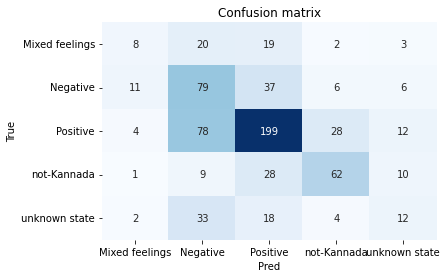

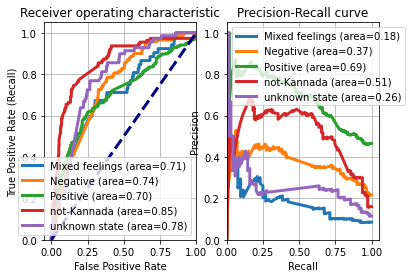

In [34]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=200, n_estimators=15, max_features=1700)

In [66]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.51
Auc: 0.75
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.24      0.08      0.12        52
      Negative       0.35      0.62      0.44       139
      Positive       0.67      0.63      0.65       321
   not-Kannada       0.56      0.45      0.49       110
 unknown state       0.24      0.13      0.17        69

      accuracy                           0.51       691
     macro avg       0.41      0.38      0.37       691
  weighted avg       0.51      0.51      0.49       691



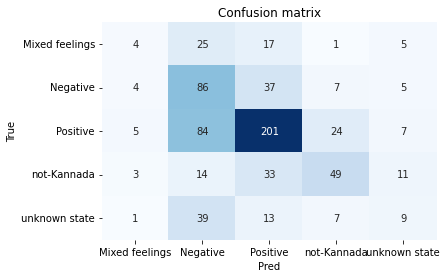

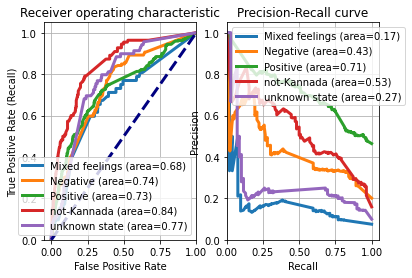

In [67]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [74]:
from sklearn.linear_model import LogisticRegression
classifier =LogisticRegression(random_state=0, max_iter= 100)

In [75]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.54
Auc: 0.78
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.40      0.04      0.07        52
      Negative       0.39      0.65      0.49       139
      Positive       0.65      0.67      0.66       321
   not-Kannada       0.53      0.42      0.47       110
 unknown state       0.43      0.23      0.30        69

      accuracy                           0.54       691
     macro avg       0.48      0.40      0.40       691
  weighted avg       0.54      0.54      0.51       691



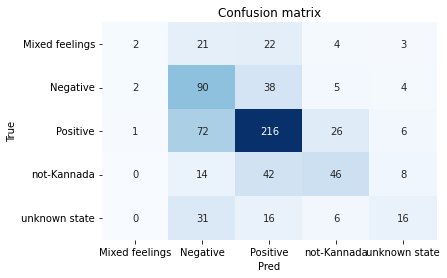

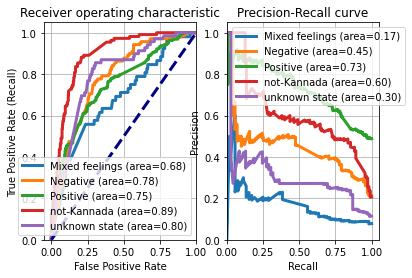

In [76]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [98]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [99]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.49
Auc: 0.69
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.22      0.15      0.18        52
      Negative       0.35      0.55      0.43       139
      Positive       0.64      0.56      0.60       321
   not-Kannada       0.52      0.55      0.54       110
 unknown state       0.28      0.16      0.20        69

      accuracy                           0.49       691
     macro avg       0.40      0.40      0.39       691
  weighted avg       0.50      0.49      0.48       691



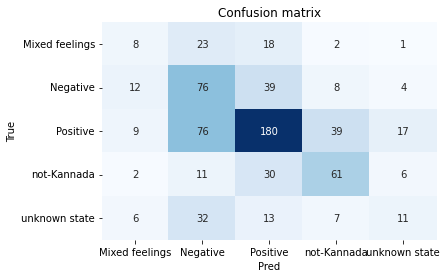

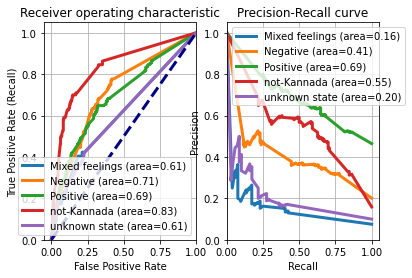

In [100]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()